<a href="https://colab.research.google.com/github/piyadalal/Optimization_Using_Evolutionary_Algorithms/blob/master/Copy_of_MNIST_NAS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This example will perform character recognition through user input into the touch screen of an STM3240G-Evaluation board using the MNIST dataset.

In [29]:
#%tensorflow_version 2.x
#!apt-get install -y xxd
!pip install deap
#! pip uninstall -y tensorflow
#! pip install -q tf-nightly
#! pip install -q tensorflow-model-optimization
!pip install numpy


Importing Tensorflow allows you to use its API to load the MNIST dataset. It should be noted that we need to use TF version <1.14 as this version includes the fully connected operation version 3 which is incompatible with the micro interpreters version 2.

In [30]:
import random

from deap import base
from deap import creator
from deap import tools
import tensorflow as tf
from tensorflow import keras

(images_train, labels_train), (images_test, labels_test) = tf.keras.datasets.mnist.load_data()

3


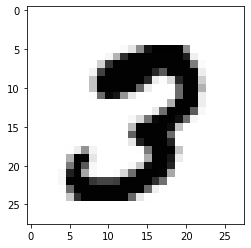

In [31]:
import matplotlib.pyplot as plt
test_index = 12345
print(labels_train[test_index])
plt.imshow(images_train[test_index], cmap='Greys')

The input of the neural network needs to know the input shape that it is going to be fed

In [32]:
input_shape = images_train.shape
print("{} images, each with shape of {} pixels x {} pixels".format(input_shape[0], input_shape[1], input_shape[2]))

60000 images, each with shape of 28 pixels x 28 pixels


The input shape for the model must be reshaped to 4D as the current shape does not show that each pixel is a 1D array where only the greyscale value (0-255) is stored. The input tensor's shape will be 3D as it will take a single-channel image. 

In [33]:
images_train = images_train.reshape(images_train.shape[0], images_train.shape[1], images_train.shape[2], 1)
images_test = images_test.reshape(images_test.shape[0], images_test.shape[1], images_test.shape[2], 1)
input_tensor_shape = (images_test.shape[1], images_test.shape[2], 1)
print("Input shape: {}".format(input_shape))

Input shape: (60000, 28, 28)


The greyscale values stores in the images' pixels are 8 bit values and need to be normalized into floats between 0-1.

In [34]:
images_train = images_train.astype('float32')
images_test = images_test.astype('float32')
images_train /= 255
images_test /= 255

Model Configuration Data structure to  store in JSON file. Double-click (or enter) to edit

In [35]:
from enum import Enum, auto
import sys

class Conv2DArgs(Enum):
  'Args needed for creating Conv2DArgs layer, list not complete'
  FILTERS = auto()
  KERNEL_SIZE = auto()
  STRIDES = auto()
  INPUT_SIZE = auto()

class MaxPool2DArgs(Enum):
  'Args needed for creating MaxPool2D layer, list not complete'
  POOL_SIZE = auto()
  STRIDES = auto()

class ReshapeArgs(Enum):
  'Args needed for creating Reshape layer'
  TARGET_SHAPE = auto()

class DenseArgs(Enum):
  'Args needed for creating Dense layer, list not complete'
  UNITS = auto()
  ACTIVATION = auto()

class DropoutArgs(Enum):
  'Args needed for creating Dropout layer, list not complete'
  RATE = auto()

class ModelLayer:
  'Common layer properties'

  def __init__(self, name):
    self.name = name
    self.args = {}

class Conv2DLayer(ModelLayer):

  def __init__(self, filters, kernel_size, strides, input_size):
    super().__init__("Conv2D")
    self.args[Conv2DArgs.FILTERS.name] = filters
    self.args[Conv2DArgs.KERNEL_SIZE.name] = kernel_size
    self.args[Conv2DArgs.STRIDES.name] = strides
    self.args[Conv2DArgs.INPUT_SIZE.name] = input_size 

  def getkeraslayer(self):
    kernel_size=self.args.get(Conv2DArgs.KERNEL_SIZE.name)
    strides=self.args.get(Conv2DArgs.STRIDES.name)
    input_shape=self.args.get(Conv2DArgs.INPUT_SIZE.name)
    return keras.layers.Conv2D(
        self.args.get(Conv2DArgs.FILTERS.name), 
        kernel_size=self.args.get(Conv2DArgs.KERNEL_SIZE.name), 
        strides=self.args.get(Conv2DArgs.STRIDES.name), 
        input_shape=self.args.get(Conv2DArgs.INPUT_SIZE.name))

class MaxPool2DLayer(ModelLayer):

  def __init__(self, pool_size, strides):
    super().__init__("MaxPool2D")
    self.args[MaxPool2DArgs.POOL_SIZE.name] = pool_size
    self.args[MaxPool2DArgs.STRIDES.name] = strides 

  def getkeraslayer(self):
    return keras.layers.MaxPool2D(
        pool_size=self.args.get(MaxPool2DArgs.POOL_SIZE.name),
        strides=self.args.get(MaxPool2DArgs.STRIDES.name)
    )

class MaxPool3DLayer(MaxPool2DLayer):

  def __init__(self, pool_size, strides):
    super(MaxPool2DLayer, self).__init__("MaxPool3D")
    super().__init__(pool_size, strides)
    
  def getkeraslayer(self):
    return keras.layers.MaxPool3D(
        pool_size=self.args.get(MaxPool2DArgs.POOL_SIZE.name),
        strides=self.args.get(MaxPool2DArgs.STRIDES.name)
    )
  
class ReshapeLayer(ModelLayer):

  def __init__(self, target_shape):
    super().__init__("Reshape")
    self.args[ReshapeArgs.TARGET_SHAPE.name] = target_shape

  def getkeraslayer(self):
    target_shape = self.args.get(ReshapeArgs.TARGET_SHAPE.name)
    return keras.layers.Reshape(target_shape)

class DenseLayer(ModelLayer):

  def __init__(self, units, activation):
    super().__init__("Dense")
    self.args[DenseArgs.UNITS.name] = units
    self.args[DenseArgs.ACTIVATION.name] = activation

  def getkeraslayer(self):
    units = self.args.get(DenseArgs.UNITS.name)
    activation = self.args.get(DenseArgs.ACTIVATION.name)
    return keras.layers.Dense(units, activation=activation)

class FlattenLayer(ModelLayer):

  def __init__(self):
    super().__init__("Flatten")

  def getkeraslayer(self):
    return keras.layers.Flatten()

class Dropout(ModelLayer):

  def __init__(self, rate):
    super().__init__("Dropout")
    self.args[DropoutArgs.RATE.name] = rate
  
  def getkeraslayer(self):
    rate = self.args.get(DropoutArgs.RATE.name)
    return keras.layers.Dropout(rate)
  

In [36]:



# I figure we can just call the layers '0', '1',...etc and this "name" is then the layer's index in the model
Model_Configuration1= {
        
    0: {
      'name': 'Conv2D',
      'args':  {
          Conv2DArgs.FILTERS.name: 28,
          Conv2DArgs.KERNEL_SIZE.name: [3,3],
          Conv2DArgs.INPUT_SIZE.name: [28,28,1]
          }
    }, 
    1: {
      'name': 'MaxPool2D',
      'args':  {
          MaxPool2DArgs.POOL_SIZE.name: [2, 2],
        }
    },
    2: {
      'name': 'Flatten'
    },
    3: {
      'name': 'Dense',
      'args': {
          DenseArgs.UNITS.name: 128,
          DenseArgs.ACTIVATION.name: "relu"
        }   
    },
    4: {
        'name': 'Dropout',
        'args':{
            DropoutArgs.RATE.name: 0.2
        }
    },
    5: {
        'name' : 'Dense',
        'args': {
        DenseArgs.UNITS.name: 128,
        DenseArgs.ACTIVATION.name: "softmax"
      }   
    } 
}

Model_Configuration2= {
        
    0: {
      'name': 'Conv2D',
      'args':  {
          Conv2DArgs.FILTERS.name: 28,
          Conv2DArgs.KERNEL_SIZE.name: [3,3],
          Conv2DArgs.INPUT_SIZE.name: [28,28,1]
          }
    }, 
    1: {
      'name': 'MaxPool2D',
      'args':  {
          MaxPool2DArgs.POOL_SIZE.name: [2, 2],
        }
    },
    2: {
      'name': 'Flatten'
    },
    3: {
      'name': 'Dense',
      'args': {
          DenseArgs.UNITS.name: 128,
          DenseArgs.ACTIVATION.name: "relu"
        }   
    }, #changed removed Dropout layer
    4: {
        'name' : 'Dense',
        'args': {
        DenseArgs.UNITS.name: 128,
        DenseArgs.ACTIVATION.name: "softmax"
      }   
    } 
}


Model_Configuration3= {
        
    0: {
      'name': 'Conv2D',
      'args':  {
          Conv2DArgs.FILTERS.name: 12, #changed
          Conv2DArgs.KERNEL_SIZE.name: [3,3],
          Conv2DArgs.INPUT_SIZE.name: [28,28,1]
          }
    }, 
    1: {
      'name': 'MaxPool2D',
      'args':  {
          MaxPool2DArgs.POOL_SIZE.name: [4, 4], #changed
        }
    },
    2: {
      'name': 'Flatten'
    },
    3: {
      'name': 'Dense',
      'args': {
          DenseArgs.UNITS.name: 128,
          DenseArgs.ACTIVATION.name: "relu"
        }   
    },
    4: {
        'name': 'Dropout',
        'args':{
            DropoutArgs.RATE.name: 0.2
        }
    },
    5: {
        'name' : 'Dense',
        'args': {
        DenseArgs.UNITS.name: 128,
        DenseArgs.ACTIVATION.name: "softmax"
      }   
    } 
}


Model_Configuration4 = {
    0: {
        'name': 'Conv2D',
        'args': {
          Conv2DArgs.FILTERS.name: 12,
          Conv2DArgs.KERNEL_SIZE.name: [3,3],
          Conv2DArgs.STRIDES.name: [2,2],
          Conv2DArgs.INPUT_SIZE.name: [28,28,1]
          }
    },
    1: {
        'name': 'Reshape',
        'args': {
            ReshapeArgs.TARGET_SHAPE.name: [13,13,12,1]
        }
    },
    2: {
        'name': "MaxPool3D",
        'args':  {
          MaxPool2DArgs.POOL_SIZE.name: [6, 3, 3],
        }
    },
    3: {
        'name': 'Flatten'
    },
    4: {
        'name' : 'Dense',
        'args': {
        DenseArgs.UNITS.name: 128,
        DenseArgs.ACTIVATION.name: "softmax"
      } 
    }
}



Reading and Writing Procedures for the JSON file

In [37]:
#Appending procedure JSON
import os
import random

def write_json(json_model, filename):
  with open("{}.json".format(filename), mode='w+') as f:
      f.write(json.dumps(json_model, indent=2))

def load_json(filename):
  if os.path.isfile("{}.json".format(filename)):
    with open("{}.json".format(filename)) as f:
        return json.load(f)

        
        


Loading the parameters from JSON file as input to our Model. JSON file is used to store list of different combination of Input parameters.

In [38]:
# # get model configuration params from our json file which is being appended
import json

write_json(Model_Configuration1, "test1")

test_read = load_json("test1")
write_json(Model_Configuration2, "test2")

test_read = load_json("test2")

write_json(Model_Configuration3, "test3")

test_read = load_json("test3")

#writing to JSON Configuration file

write_json(Model_Configuration4, "test4")

test_read4 = load_json("test4")

For Model_Configuration1, the the convolutional NN that we will use to classify the input images taken from the touch screen will have the following layer structure

1. Conv2D
2. MaxPooling2D
3. Flatten
4. Dense
5. Dropout
11. Dense

**Implementation of NSGA-II Algorithm (Deap)**

We need first to define our individual, strategy and fitness as datatypes.The first argument gives the datatype name, the second gives the base class, which is the base class for fitness measures provided by DEAP and the third argument sets the fitness weight to a negative value, which means that the evolutionary optimization will try to minimize this value.

In [79]:
# creator is a class factory that can build new classes at run-time
creator.create("FitnessMulti", base.Fitness, weights=(-1.0, ))

/usr/local/lib/python3.6/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


On running the above cell the datatype FitnessMin is added dynamically to the creator subpackage and we can access it directly as ‘creator.FitnessMin’.

**Defining our Individual** :It defines the individual. Starting from the fourth argument, any arguments you provide, will be added as fields or attributes to the defined datatype.  

In [80]:
creator.create("Individual", dict, fitness=creator.FitnessMulti)

/usr/local/lib/python3.6/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


For the individual, we define a necessary one required by DEAP, which is fitness. DEAP will look for this one when it wants to update the fitness value or read it, ex. fitness Minimum as one of the argument is passed into the function.

 The strategy attribute is needed by the ES algorithm, since it depends on a strategy vector for doing the mutations.Initialized to ‘None’, as we are populating it ourselves. 

In [81]:
# a toolbox stores functions and their arguments
toolbox = base.Toolbox()


In [82]:
def initIndividual(icls, content):
    return icls(content)

def initPopulation(pcls, ind_init, filename):
    with open(filename, "r") as pop_file:
       contents = json.load(pop_file)
       for c in contents: 
         return pcls(ind_init(c) for c in contents)

toolbox.register("population", initPopulation, list, creator.Individual, "Test.json")

population=toolbox.population()
#population=toolbox.population_guess()
# print(population[0])
# print(population[1])
# print(type(population))


The Conv2D layer extracts features from the input image using filters that slide across the input image. In this case we will use 28 different filters to extract a large number of unique features that will then be used to classify each image in the later layers. Thus the output of this layer will have the shape (28, 28, 1, 28)

MaxPooling2D is used to reduce the output size of the convolutional layer by reducing each 2 x 2 unique chunk of the output down in to a singular value, this reducing the output's size by a factor of 4. This will reduce our (28, 28, 1, 28) tensor down to a (7, 7, 1, 28) tensor.

The Flatten layer then takes this 2D array (our image) and shapes it into a single dimension (1372).

The following Dense layer reduces the input 1372 values down into 128 classes, taking the first steps in classifying the image into on of the 10 output classes (0-9). This is done using the relu activation function.

The Dropout layer sets 20% of the tensor's values to 0 so as to reduce overfitting.

Finally the last Dense layer reduces the output value down to the 10 classes, each representing a digit between 0 and 9. This is done using the softmax activation function which makes the outputs a set of probabilities summing to 1.


In [106]:

class Model:

  def __init__(self, json, optimizer='adam', 
               loss='sparse_categorical_crossentropy', metrics=['accuracy']):
    self.optimizer = optimizer
    self.loss = loss
    self.metrics = metrics
    self.layer = []
    layer_no=json.keys()
    for layer in layer_no:
      name= json[str(layer)]["name"]
      if name == "Conv2D":
        arg=json[str(layer)]["args"]
        #print("entered conv2d")
        filters = arg["FILTERS"]
        kernel = arg["KERNEL_SIZE"]
        kernel_size = tuple(kernel)
        input = arg["INPUT_SIZE"]
        input_size = tuple(input)
        if "STRIDES" not in arg.keys():
          strides =(1,1)
        else:
          strides =arg["STRIDES"]
        self.layer.append(Conv2DLayer(filters, kernel_size, strides, input_size))
        #print("Created {} layer with {} filters, {} kernel size, {} stride size and {} input size".format(
        #name, filters, kernel_size, strides, input_size
      #))
      elif name == "MaxPool2D" or name == "MaxPool3D":
        arg=json[str(layer)]["args"]
        pool_size = arg["POOL_SIZE"]
        strides = None
        if name == "MaxPool2D":
          arg=json[str(layer)]["args"]
          self.layer.append(MaxPool2DLayer(pool_size, strides))
          #print("Created {} layer with {} pool size and {} stride size".format(
              #name, pool_size, strides
          #))
        else:
          arg=json[str(layer)]["args"]
          self.layer.append(MaxPool3DLayer(pool_size, strides))
          #print("Created {} layer with {} pool size and {} stride size".format(
              #name, pool_size, strides
        #))
      elif name == "Reshape":
        #print("entered reshape")
        arg=json[str(layer)]["args"]
        target_shape = arg["TARGET_SHAPE"]
        self.layer.append(ReshapeLayer(target_shape))
        #print(" Created {} layer with {} target shape".format(name, target_shape))
      elif name == "Dense":
        arg=json[str(layer)]["args"]
        units = arg["UNITS"]
        activation = getattr(tf.nn, arg["ACTIVATION"])
        self.layer.append(DenseLayer(units, activation))
        #print("Created {} layer with {} units and {} activation".format(name, units, activation))
      elif name == "Flatten":
        self.layer.append(FlattenLayer())
        #print("Created {} layer".format(name))
      elif name == "Dropout": 
        arg=json[str(layer)]["args"]
        rate = arg["RATE"]
        self.layer.append(Dropout(rate))
        #print("Created {} layers with {} rate".format(name, rate))
      #print(self.layer)

  def gettfmodel(self):
    model = keras.Sequential()
    for layer in self.layer:
      model.add(layer.getkeraslayer())
    #print(model)
    model.compile(optimizer=self.optimizer, loss=self.loss, metrics=self.metrics)
    return model


In [ ]:
# count=0
# print(population)
# print(population[0])
# print(population[1])
# print(population[2])
# print(population[3])
# print(len(population))

Train the Model:

In [107]:




# test_model1=Model(population[0])
# tf_model1 = test_model1.gettfmodel()
# history = tf_model1.fit(x=images_train,y=labels_train, epochs=1, batch_size=100)
# tf_model1.summary()



  #print(every_individual)
  # test_model1=Model(every_individual)
  # tf_model1 = test_model1.gettfmodel()
  # print(images_train.shape)
  # print(labels_train.shape)
  # tf_model1.summary()
  # arg=every_individual[str(layer)]["args"]

  # If 


[{'0': {'name': 'Conv2D', 'args': {'FILTERS': 28, 'KERNEL_SIZE': [3, 3], 'INPUT_SIZE': [28, 28, 1]}}, '1': {'name': 'MaxPool2D', 'args': {'POOL_SIZE': [2, 2]}}, '2': {'name': 'Flatten'}, '3': {'name': 'Dense', 'args': {'UNITS': 128, 'ACTIVATION': 'relu'}}, '4': {'name': 'Dense', 'args': {'UNITS': 128, 'ACTIVATION': 'softmax'}}}, {'0': {'name': 'Conv2D', 'args': {'FILTERS': 28, 'KERNEL_SIZE': [3, 3], 'INPUT_SIZE': [28, 28, 1]}}, '1': {'name': 'MaxPool2D', 'args': {'POOL_SIZE': [2, 2]}}, '2': {'name': 'Flatten'}, '3': {'name': 'Dense', 'args': {'UNITS': 128, 'ACTIVATION': 'relu'}}, '4': {'name': 'Dropout', 'args': {'RATE': 0.2}}, '5': {'name': 'Dense', 'args': {'UNITS': 128, 'ACTIVATION': 'softmax'}}}, {'0': {'name': 'Conv2D', 'args': {'FILTERS': 12, 'KERNEL_SIZE': [3, 3], 'INPUT_SIZE': [28, 28, 1]}}, '1': {'name': 'MaxPool2D', 'args': {'POOL_SIZE': [4, 4]}}, '2': {'name': 'Flatten'}, '3': {'name': 'Dense', 'args': {'UNITS': 128, 'ACTIVATION': 'relu'}}, '4': {'name': 'Dropout', 'args': {

In [108]:

# test_model2=Model(population[1])
# tf_model2= test_model2.gettfmodel()
# history = tf_model2.fit(x=images_train,y=labels_train, epochs=1, batch_size=100)

# # tf_model2.summary()

In [109]:

# test_model3=Model(population[2])
# tf_model3= test_model3.gettfmodel()
# history = tf_model3.fit(x=images_train,y=labels_train, epochs=1, batch_size=100)

# tf_model3.summary()

In [110]:

# test_model4=Model(population[3])
# tf_model4= test_model4.gettfmodel()
# history = tf_model4.fit(x=images_train,y=labels_train, epochs=1, batch_size=100)
# tf_model4.summary()


In [111]:
# from keras.utils.layer_utils import count_params
#  #Model_1 trainable Parameters

# Total_Params_Model1= count_params(tf_model1.trainable_weights)+count_params(tf_model1.non_trainable_weights)
# print(Total_Params_Model1)

# Total_Params_Model2=count_params(tf_model2.trainable_weights)+count_params(tf_model2.non_trainable_weights)
# print(Total_Params_Model2)

# Total_Params_Model3=count_params(tf_model3.trainable_weights)+count_params(tf_model3.non_trainable_weights)
# print(Total_Params_Model3)

# Total_Params_Model4=count_params(tf_model4.trainable_weights)+count_params(tf_model4.non_trainable_weights)
# print(Total_Params_Model4)


In [112]:
# res = tf_model1.evaluate(images_test, labels_test)
# res_2 = tf_model2.evaluate(images_test, labels_test)
# res_3 = tf_model3.evaluate(images_test, labels_test)
# res_4 = tf_model4.evaluate(images_test, labels_test)
# print(res)

# #Writing the required output parameters to be optimized to out
# Model1={
#     "Accuracy":res[1],
#     "Params": Total_Params_Model1
# }

# Model2={
#     "Accuracy":res_2[1],
#     "Params": Total_Params_Model2
# }

# Model3={
#     "Accuracy":res_3[1],
#     "Params": Total_Params_Model3
# }

# Model4={
#     "Accuracy":res_4[1],
#     "Params": Total_Params_Model4
# }


# Model1["Accuracy"] =res[1], 
#  {(, Total_Params_Model1)}
# dict[ "Model2" ] = {(res_2[1],Total_Params_Model2)}
# dict[ "Model3" ] = {(res_3[1],Total_Params_Model3)}
# dict[ "Model4" ] = {(res_4[1],Total_Params_Model4)}

In [113]:
def evalCNN(population):
  outparam={}
  test_model=Model(population)
  tf_model= test_model.gettfmodel()
  history = tf_model.fit(x=images_train,y=labels_train, epochs=1, batch_size=100)
  res = tf_model.evaluate(images_test, labels_test)
  Total_Params=count_params(tf_model.trainable_weights)+count_params(tf_model.non_trainable_weights)
  return res[0],Total_Params           # Ensure overweighted bags are dominated

In [114]:
toolbox.register("evaluate", evalCNN)
toolbox.register("select", tools.selNSGA2)

In [116]:
# begin the evolution
# random.seed(64)

# instantiate a population
CXPB, MUTPB, NGEN = 0.0, 0.0, 10
for g in range(NGEN):
    print("-- Generation %i --" % g)

    # select the next generation individuals
    offspring = toolbox.select(population, len(population))
    print(offspring)
    # clone the selected individuals
    offspring = list(map(toolbox.clone, offspring))

    # # apply crossover and mutation on the offspring
    # for child1, child2 in zip(offspring[::2], offspring[1::2]):
    #     if random.random() < CXPB:
    #         toolbox.mate(child1, child2)
    #         del child1.fitness.values
    #         del child2.fitness.values

    # for mutant in offspring:
    #     if random.random() < MUTPB:
    #         toolbox.mutate(mutant)
    #         del mutant.fitness.values

    # evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    # fitnesses = map(toolbox.evaluate, invalid_ind)
    # for ind, fit in zip(invalid_ind, fitnesses):
    #     ind.fitness.values = fit

    # print("  Evaluated %i individuals" % len(invalid_ind))

    # evaluate the entire population
    fitnesses = list(map(toolbox.evaluate, population))
    print(fitnesses)
    for ind, fit in zip(population, fitnesses):
      ind.fitness.values = fit

    print("  Evaluated %i individuals" % len(population))

    # the population is entirely replaced by the offspring
    population[:] = offspring

    # gather all the fitnesses in one list and print the stats
    fits = [ind.fitness.values[0] for ind in population]

    length = len(population)
    mean = sum(fits) / length
    sum2 = sum(x*x for x in fits)
    std = abs(sum2 / length - mean**2)**0.5
 #As there is no mating, the population doesn't improve
    print("  Min %s" % min(fits))
    print("  Max %s" % max(fits))
    print("  Avg %s" % mean)
    print("  Std %s" % std)

-- Generation 0 --
[{'0': {'name': 'Conv2D', 'args': {'FILTERS': 28, 'KERNEL_SIZE': [3, 3], 'INPUT_SIZE': [28, 28, 1]}}, '1': {'name': 'MaxPool2D', 'args': {'POOL_SIZE': [2, 2]}}, '2': {'name': 'Flatten'}, '3': {'name': 'Dense', 'args': {'UNITS': 128, 'ACTIVATION': 'relu'}}, '4': {'name': 'Dense', 'args': {'UNITS': 128, 'ACTIVATION': 'softmax'}}}, {'0': {'name': 'Conv2D', 'args': {'FILTERS': 28, 'KERNEL_SIZE': [3, 3], 'INPUT_SIZE': [28, 28, 1]}}, '1': {'name': 'MaxPool2D', 'args': {'POOL_SIZE': [2, 2]}}, '2': {'name': 'Flatten'}, '3': {'name': 'Dense', 'args': {'UNITS': 128, 'ACTIVATION': 'relu'}}, '4': {'name': 'Dropout', 'args': {'RATE': 0.2}}, '5': {'name': 'Dense', 'args': {'UNITS': 128, 'ACTIVATION': 'softmax'}}}, {'0': {'name': 'Conv2D', 'args': {'FILTERS': 12, 'KERNEL_SIZE': [3, 3], 'INPUT_SIZE': [28, 28, 1]}}, '1': {'name': 'MaxPool2D', 'args': {'POOL_SIZE': [4, 4]}}, '2': {'name': 'Flatten'}, '3': {'name': 'Dense', 'args': {'UNITS': 128, 'ACTIVATION': 'relu'}}, '4': {'name': '

In [117]:
best_ind = tools.selBest(population, 1)[0]
print("Best individual is %s, %s" % (best_ind, best_ind.fitness.values))

Best individual is {'0': {'name': 'Conv2D', 'args': {'FILTERS': 28, 'KERNEL_SIZE': [3, 3], 'INPUT_SIZE': [28, 28, 1]}}, '1': {'name': 'MaxPool2D', 'args': {'POOL_SIZE': [2, 2]}}, '2': {'name': 'Flatten'}, '3': {'name': 'Dense', 'args': {'UNITS': 128, 'ACTIVATION': 'relu'}}, '4': {'name': 'Dense', 'args': {'UNITS': 128, 'ACTIVATION': 'softmax'}}}, (0.1404014676809311,)


In [ ]:
# get model configuration params from our json file
# import json 
# with open('Model_Configuration.json') as example_data:
#     data = json.load(example_data)
# print(data['layer1']['layer1_name'])
# int(data['layer1']['param1'])


In [ ]:
#layer types and shapes changed in each model

#import tensorflow_model_optimization as tfmot

#quantize_model = tfmot.quantization.keras.quantize_model
# model = keras.Sequential()

# if (data[count]['layer1']['layer1_name']=='Conv2D'):
#     model.add(keras.layers.Conv2D(int(data[count]['layer1']['param1']), kernel_size=(int(data[count]['layer1']['param2']),int(data[count]['layer1']['param3'])), input_shape=input_tensor_shape))
# if (data[count]['layer2']['layer2_name']=='Maxpool'):
#     model.add(keras.layers.MaxPooling2D(pool_size=(int(data[count]['layer2']['param1']),int(data[count]['layer2']['param2']))))         
# model.add(keras.layers.Flatten()) # Flattening the 2D arrays for fully connected layers
# model.add(keras.layers.Dense(128, activation=tf.nn.relu))
# model.add(keras.layers.Dropout(0.2))
# model.add(keras.layers.Dense(10,activation=tf.nn.softmax))


#quantized_model5 = quantize_model(model5)

In [ ]:
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# #quantized_model5.compile(optimizer='adam',
#               #loss='sparse_categorical_crossentropy',
#               #metrics=['accuracy'])

# batch_size = 100
# epochs = 10

# print("Model 1")
# history = model.fit(x=images_train,y=labels_train, epochs=epochs, batch_size=batch_size)
# model.summary()




Now we can evaluate our trained model using the test data

Writing our final results back to our JSON file

In [ ]:
#Appending procedure JSON
import os
a = []
write_json(result, "test_result")
# if not os.path.isfile("/Users/priyadalal/Desktop/result.json"):
#     a.append(result)
#     with open("/Users/priyadalal/Desktop/result.json", mode='w') as f:
#         f.write(json.dumps(a, indent=2))
# else:
#     with open("/Users/priyadalal/Desktop/result.json") as feedsjson:
#         feeds = json.load(feedsjson)

#     feeds.append(result)
#     with open("/Users/priyadalal/Desktop/result.json", mode='w') as f:
#         f.write(json.dumps(feeds, indent=2))

In [ ]:
#Updating our counter on completing the Iteration 
#count=count+1

NameError: ignored